# Model

## Environment setup

In [1]:
# Connect with Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Paths

BASE_PATH = "/content/drive/MyDrive/TEC/AI/ProyectoBenji"

PATHS = {
  "CLEAN_DATA_PATH": f"{BASE_PATH}/data/clean",
  "PROCESSED_DATA_PATH": f"{BASE_PATH}/data/processed",
  "MODELS_PATH": f"{BASE_PATH}/models"
}

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# SciKit Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# TensorFlow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from collections import Counter
import pickle
import warnings
import os

warnings.filterwarnings('ignore')

In [4]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Detected: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"  - {gpu.name} ({gpu.device_type})")

    print("\nTensorFlow is configured to use the GPU.")
else:
    print("No GPU Detected. Please enable it in Runtime > Change runtime type > Hardware accelerator.")

No GPU Detected. Please enable it in Runtime > Change runtime type > Hardware accelerator.


## Data collection

In [5]:
# Parquet path
parquet_path = f"{PATHS['CLEAN_DATA_PATH']}/yelp_reviews_cleaned.parquet"

yelp_df = pd.read_parquet(parquet_path)

# Show info to understand structure
print("\nInfo of Yelp Reviews:")
yelp_df.info()

# Sample
yelp_df_display = yelp_df.copy()
yelp_df_display['tokens_filtered'] = yelp_df_display['tokens_filtered'].apply(lambda x: ' '.join(x))

print("\nSample:")
print(yelp_df_display.head().to_markdown(index=False))


Info of Yelp Reviews:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199131 entries, 0 to 199130
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             199131 non-null  object
 1   sentiment        199131 non-null  object
 2   text_length      199131 non-null  int64 
 3   word_count       199131 non-null  int64 
 4   text_clean       199131 non-null  object
 5   tokens           199131 non-null  object
 6   tokens_filtered  199131 non-null  object
dtypes: int64(2), object(5)
memory usage: 10.6+ MB

Sample:
| text                                                                                                                                                                                                                                                                                                                                                                                                   

## Data preparation



I'll divide the dataset into three distinct subsets to ensure proper model evaluation:
* Training Set (70%): Used to train the model weights.
* Validation Set (15%): Used to tune hyperparameters and monitor for overfitting.
* Test Set (15%): Used only once at the end to evaluate the final model.

In [6]:
# Split data into train, validation and test

# Split: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(yelp_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df):,}")
print(f"Validation: {len(val_df):,}")
print(f"Test: {len(test_df):,}")

Train: 139,391
Validation: 29,870
Test: 29,870


I'll separate the raw data into features and targets:
* Features (X): The 'tokens_filtered' column (cleaned text tokens).
* Labels (y): The 'sentiment' column (class labels).

In [7]:
# Extract text and labels

print("\nExtracting tokens and labels...")

train_tokens = train_df['tokens_filtered'].fillna('').tolist()
val_tokens = val_df['tokens_filtered'].fillna('').tolist()
test_tokens = test_df['tokens_filtered'].fillna('').tolist()

train_labels = train_df['sentiment'].tolist()
val_labels = val_df['sentiment'].tolist()
test_labels = test_df['sentiment'].tolist()

print(f"\nExample tokens: {train_tokens[0][:10]}")


Extracting tokens and labels...

Example tokens: ['shouldve' 'known' 'going' 'wild' 'ride' 'arent' 'capable' 'serving'
 'full' 'quiznos']


Machine learning models require numerical input. I'll use LabelEncoder to convert the string sentiment labels into integers:
* negative -> 0
* neutral  -> 1
* positive -> 2

In [8]:
# Encode labels

print("\nEncoding labels...")

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print(f"Classes: {label_encoder.classes_}")
print(f"Label distribution (train): {np.bincount(train_labels_encoded)}")


Encoding labels...
Classes: ['negative' 'neutral' 'positive']
Label distribution (train): [46628 46469 46294]


I'll create a vocabulary of the top 20,000 most frequent words in the training set.
* <PAD> (Index 0): Reserved for padding sequences.
* <OOV> (Index 1): Reserved for "Out Of Vocabulary" words.

In [9]:
# Build vocabulary from training tokens

print("\nBuilding vocabulary from tokens...")

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 200

# Count all words in training set
all_words = []
for tokens in train_tokens:
  all_words.extend(tokens)

word_counts = Counter(all_words)
print(f"\nTotal unique words in training: {len(word_counts):,}")

# Keep only top MAX_VOCAB_SIZE words
most_common = word_counts.most_common(MAX_VOCAB_SIZE - 2)  # -2 for <PAD> and <OOV>

# Create word-to-index mapping
word_to_index = {'<PAD>': 0, '<OOV>': 1}  # Reserve 0 for padding, 1 for unknown
for idx, (word, count) in enumerate(most_common, start=2):
  word_to_index[word] = idx

print(f"\nVocabulary size (including <PAD> and <OOV>): {len(word_to_index):,}")
print(f"\nUsing top {MAX_VOCAB_SIZE:,} words")


Building vocabulary from tokens...

Total unique words in training: 133,668

Vocabulary size (including <PAD> and <OOV>): 20,000

Using top 20,000 words


I'll replace every word in the reviews with its corresponding integer index.
* Words in dictionary -> mapped to index.
* Words not in dictionary -> mapped to <OOV> (Index 1).

In [10]:
# Converting tokens to numerical sequences

print("\nConverting tokens to numerical sequences...")

def tokens_to_sequences(tokens_list, word_to_index):
  sequences = []
  for tokens in tokens_list:
    sequence = [word_to_index.get(token, 1) for token in tokens]  # 1 = <OOV>
    sequences.append(sequence)
  return sequences

train_sequences = tokens_to_sequences(train_tokens, word_to_index)
val_sequences = tokens_to_sequences(val_tokens, word_to_index)
test_sequences = tokens_to_sequences(test_tokens, word_to_index)

print(f"\nExample transformation:")
print(f"    Tokens: {train_tokens[0][:10]}")
print(f"    Sequence: {train_sequences[0][:10]}")


Converting tokens to numerical sequences...

Example transformation:
    Tokens: ['shouldve' 'known' 'going' 'wild' 'ride' 'arent' 'capable' 'serving'
 'full' 'quiznos']
    Sequence: [2473, 1094, 53, 2334, 1471, 666, 6493, 741, 202, 11272]


I'll standardize the length of all sequences to 200 tokens for the LSTM.
* Shorter sequences -> padded with zeros (Index 0) at the end.
* Longer sequences -> truncated to keep only the first 200 tokens.

In [11]:
# Pad sequences

print("\nPadding sequences to same length...")

train_padded = pad_sequences(
  train_sequences,
  maxlen=MAX_SEQUENCE_LENGTH,
  padding='post',
  truncating='post',
  value=0
)

val_padded = pad_sequences(
  val_sequences,
  maxlen=MAX_SEQUENCE_LENGTH,
  padding='post',
  truncating='post',
  value=0
)

test_padded = pad_sequences(
    test_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post',
    value=0
)

print(f"Train shape: {train_padded.shape}")
print(f"Val shape: {val_padded.shape}")
print(f"Test shape: {test_padded.shape}")


Padding sequences to same length...
Train shape: (139391, 200)
Val shape: (29870, 200)
Test shape: (29870, 200)


Convert integer labels to categorical format (one-hot encoding) for the loss function. Then, save all processed arrays (.npy) and encoder objects (.pkl) to disk for later use.

In [12]:
# Convert to categorical

import os

train_labels_cat = to_categorical(train_labels_encoded, num_classes=3)
val_labels_cat = to_categorical(val_labels_encoded, num_classes=3)
test_labels_cat = to_categorical(test_labels_encoded, num_classes=3)

print(f"\nData preparation complete!")
print(f"Label shape: {train_labels_cat.shape}")

# Save for later use
print("\nSaving preprocessed data...")

# Create the directory if it doesn't exist
os.makedirs(PATHS["PROCESSED_DATA_PATH"], exist_ok=True)

np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/train_padded.npy', train_padded)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/val_padded.npy', val_padded)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/test_padded.npy', test_padded)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/train_labels_cat.npy', train_labels_cat)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/val_labels_cat.npy', val_labels_cat)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/test_labels_cat.npy', test_labels_cat)

with open(f'{PATHS["PROCESSED_DATA_PATH"]}/word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)
with open(f'{PATHS["PROCESSED_DATA_PATH"]}/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Store for model building
VOCAB_SIZE = len(word_to_index)

print(f"Saved to {PATHS['PROCESSED_DATA_PATH']}")
print(f"\nFinal vocabulary size: {VOCAB_SIZE:,}")


Data preparation complete!
Label shape: (139391, 3)

Saving preprocessed data...
Saved to /content/drive/MyDrive/TEC/AI/ProyectoBenji/data/processed

Final vocabulary size: 20,000


## GloVe Embeddings Setup

We will use pre-trained GloVe embeddings (100d) to initialize our embedding layer. This helps the model understand semantic relationships between words from the start.

In [13]:
# Download GloVe embeddings if not present
import os
import zipfile

EMBEDDINGS_PATH = f"{BASE_PATH}/data/embeddings"
os.makedirs(EMBEDDINGS_PATH, exist_ok=True)

glove_zip = f"{EMBEDDINGS_PATH}/glove.6B.zip"
glove_txt = f"{EMBEDDINGS_PATH}/glove.6B.100d.txt"

if not os.path.exists(glove_txt):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings (this may take a while)...")
        !wget http://nlp.stanford.edu/data/glove.6B.zip -O {glove_zip}

    print("Unzipping GloVe embeddings...")
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall(EMBEDDINGS_PATH)
    print("GloVe embeddings ready.")
else:
    print("GloVe embeddings already present.")

GloVe embeddings already present.


In [14]:
# Load GloVe embeddings
print("Loading GloVe embeddings...")

embeddings_index = {}
with open(glove_txt, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index):,} word vectors.")

# Create embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
hits = 0
misses = 0

for word, i in word_to_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

print(f"Converted {hits:,} words ({hits/VOCAB_SIZE:.1%})")
print(f"Missed {misses:,} words ({misses/VOCAB_SIZE:.1%})")

Loading GloVe embeddings...
Found 400,000 word vectors.
Converted 18,847 words (94.2%)
Missed 1,153 words (5.8%)


## Model with GloVe Embeddings

### Model architecture

This specific architecture is designed for sequence classification:

1. Embedding Layer (100 dim): Transforms sparse integer indices (words) into dense vectors using pre-trained GloVe embeddings.

2. SpatialDropout1D (0.2): Drops entire 1D feature maps instead of individual elements to help prevent overfitting within the embedding space.

3. Convolutional Block (Conv1D + BatchNorm + MaxPool): Extracts local n-gram features from the text using 128 filters of size 3, followed by Batch Normalization and MaxPooling to reduce dimensionality.

4. Bidirectional LSTM (64 units): Processes the feature sequence in both directions. It returns the full sequence of hidden states (`return_sequences=True`) to capture context over time.

5. GlobalMaxPooling1D: Extracts the most important features (highest activation) from the entire sequence of LSTM outputs, acting as a simplified attention mechanism.

6. Dense Layer (64 units): A fully connected hidden layer with L2 regularization to interpret the extracted features.

7. Dropout (0.5): A regularization layer that randomly drops 50% of the connections during training to prevent overfitting.

8. Dense Output (3 units): The final layer with 'softmax' activation. It outputs a probability distribution across the 3 classes (Negative, Neutral, Positive).

In [15]:

# Model architecture

# Model parameters
VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_DIM = 100  # GloVe 100d
LSTM_UNITS = 64  # LSTM hidden state size
DROPOUT_RATE = 0.5 # Standard regularization
SPACIAL_DROPOUT_RATE = 0.2 # Lower because pre-trained embeddings are cleaner

# Model
model = Sequential([
    # 1. Embedding Layer (learns word representations)
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    ),

    # 2. Spatial Dropout
    # Drops entire 1D feature maps instead of individual elements.
    # Helps prevent overfitting within the embedding space.
    SpatialDropout1D(SPACIAL_DROPOUT_RATE, name='spatial_dropout'),

    # 3. Convolutional Block (Local Feature Extraction)
    # Extracts local n-grams (phrases). use_bias=False is optimized here
    # because BatchNormalization immediately follows (which has its own bias term).
    Conv1D(filters=128, kernel_size=3, padding='valid', use_bias=False, name='conv1d'),
    BatchNormalization(name='batch_norm'),
    Activation('relu', name='cnn_activation'),
    MaxPooling1D(pool_size=2, name='max_pooling_cnn'),


    # 4. Bidirectional LSTM
    # return_sequences=True is MANDATORY here. It preserves the time dimension
    # so the next layer (GlobalMax) can scan the whole sentence, not just the end.
    # recurrent_dropout=0 is used to enable CuDNN (GPU) acceleration.
    Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0),
        name='bidirectional_lstm'
    ),

    # 5. Simulated Attention (Global Max Pooling)
    # Instead of relying on the last hidden state, this extracts the strongest
    # sentiment signal (highest activation) found anywhere in the sequence.
    GlobalMaxPooling1D(name='global_max_pooling'),

    # 6. Dense Hidden Layer
    # Includes L2 regularization to penalize large weights and reduce overfitting.
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_hidden'),

    # Standard Dropout for the dense layer
    Dropout(DROPOUT_RATE, name='dropout_regularization'),

    # 7. Output Layer
    # 3 neurons for the 3 classes (Negative, Neutral, Positive)
    Dense(3, activation='softmax', name='output')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Show architecture
print("\n Model Summary:")
model.summary()


 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout                 │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_activation (Activation)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_cnn (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_regularization          │ ?                      │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [16]:
# Training parameters

BATCH_SIZE = 32
EPOCHS = 20

# Callbacks
callbacks = [
    # Early stopping: stop if val_loss doesn't improve for 3 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        f'{PATHS["MODELS_PATH"]}/baseline_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate if stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=0.00001
    )
]

print(f"\n Training parameters:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Callbacks: Early Stopping, Model Checkpoint, LR Reduction")


 Training parameters:
   Batch size: 32
   Max epochs: 20
   Callbacks: Early Stopping, Model Checkpoint, LR Reduction


### Training

In [17]:
# Train

upgraded_model_path = f'{PATHS["MODELS_PATH"]}/upgraded_model.keras'
upgraded_model_training_history_path = f'{PATHS["MODELS_PATH"]}/upgraded_model_training_history.pkl'

# Check if model exists to avoid retraining
if os.path.exists(upgraded_model_path) and os.path.exists(upgraded_model_training_history_path):
    print(f"\nModel found at {upgraded_model_path}. Loading...")
    model = tf.keras.models.load_model(upgraded_model_path)
    print("Model loaded successfully. Skipping training.")
else:
    print("\nStarting training...\n")

    # Train model
    history = model.fit(
        train_padded,
        train_labels_cat,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(val_padded, val_labels_cat),
        callbacks=callbacks,
        verbose=1
    )

    print("\nTraining complete!")

    # Save final model
    model.save(upgraded_model_path)
    print(f"Model saved to {upgraded_model_path}")

    # Save history
    with open(upgraded_model_training_history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"Training history saved to {upgraded_model_training_history_path}")


Model found at /content/drive/MyDrive/TEC/AI/ProyectoBenji/models/upgraded_model.keras. Loading...
Model loaded successfully. Skipping training.


### Results


Loading training history...
Training statistics:

Best epoch: 20/20
Best validation accuracy: 0.7849 (78.49%)
Best validation loss: 0.5173

Final epoch:
    Train accuracy: 0.7905 (79.05%)
    Val accuracy: 0.7849 (78.49%)

Good generalization (gap: 0.0056)

Generating Confusion Matrix on Test Set...
934/934 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step


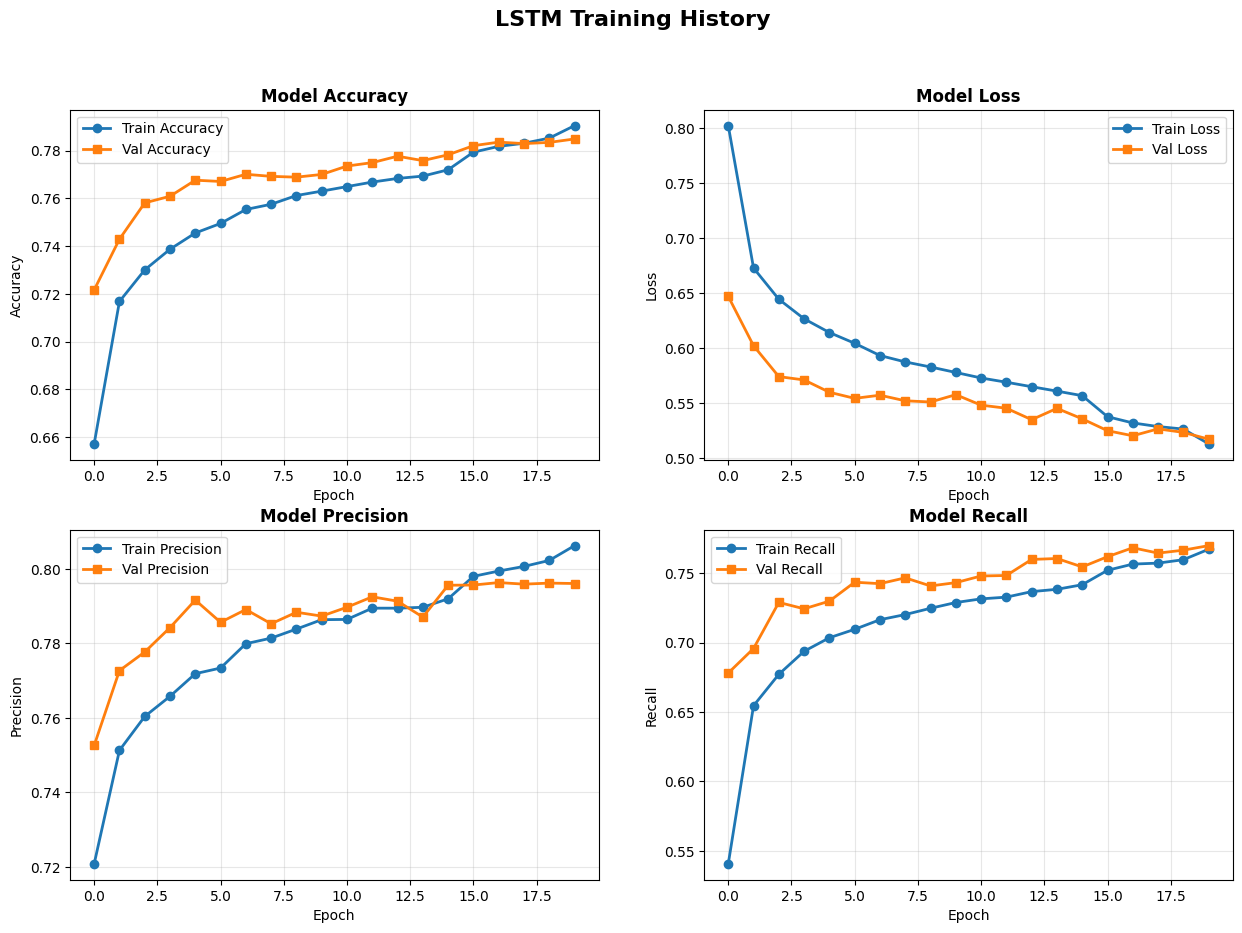

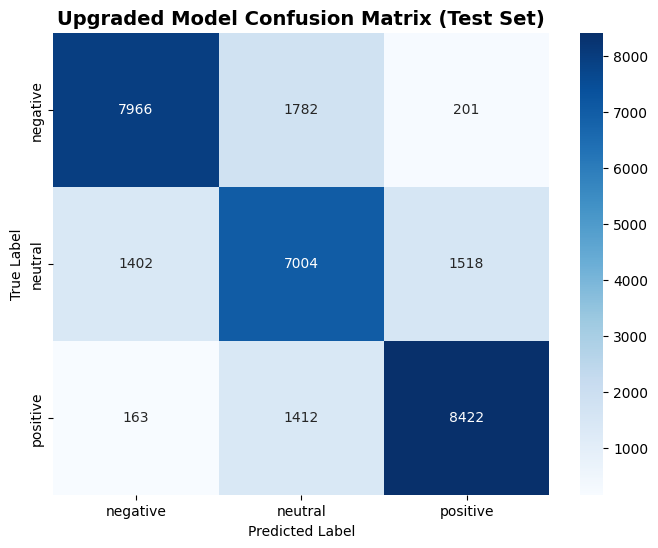

In [18]:
# Results

# Load training history
print("\nLoading training history...")

with open(upgraded_model_training_history_path, 'rb') as f:
    history_dict = pickle.load(f)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LSTM Training History', fontsize=16, fontweight='bold')

# 1. Accuracy
axes[0, 0].plot(history_dict['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0, 0].plot(history_dict['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss
axes[0, 1].plot(history_dict['loss'], label='Train Loss', linewidth=2, marker='o')
axes[0, 1].plot(history_dict['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision
axes[1, 0].plot(history_dict['precision'], label='Train Precision', linewidth=2, marker='o')
axes[1, 0].plot(history_dict['val_precision'], label='Val Precision', linewidth=2, marker='s')
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Recall
axes[1, 1].plot(history_dict['recall'], label='Train Recall', linewidth=2, marker='o')
axes[1, 1].plot(history_dict['val_recall'], label='Val Recall', linewidth=2, marker='s')
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Print statistics
print("Training statistics:")

best_epoch = np.argmax(history_dict['val_accuracy']) + 1
best_val_acc = np.max(history_dict['val_accuracy'])
best_val_loss = np.min(history_dict['val_loss'])
final_train_acc = history_dict['accuracy'][-1]
final_val_acc = history_dict['val_accuracy'][-1]

print(f"\nBest epoch: {best_epoch}/{len(history_dict['loss'])}")
print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"\nFinal epoch:")
print(f"    Train accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"    Val accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Check for overfitting
overfit_gap = final_train_acc - final_val_acc
if overfit_gap > 0.1:
    print(f"\nPotential overfitting detected (gap: {overfit_gap:.4f})")
elif overfit_gap > 0.05:
    print(f"\nSlight overfitting (gap: {overfit_gap:.4f})")
else:
    print(f"\nGood generalization (gap: {overfit_gap:.4f})")

# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\nGenerating Confusion Matrix on Test Set...")
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_cat, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Upgraded Model Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Fine-tune model

In [19]:
# 1. Unfreeze the Embedding layer
model.layers[0].trainable = True

# 2. Recompile the model
# I'll use a VERY LOW Learning Rate (e.g., 1e-5).
# If I use the standard (1e-3), I'll destroy the GloVe weights and the model will forget everything.
optimizer = Adam(learning_rate=1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [20]:
# Callbacks
callbacks_finetune = [
    # Early stopping: stop if val_loss doesn't improve for 3 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        f'{PATHS["MODELS_PATH"]}/finetuned_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate if stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=0.00001
    )
]

In [21]:
finetunned_model_path = f'{PATHS["MODELS_PATH"]}/finetunned_model.keras'
finetunned_model_training_history_path = f'{PATHS["MODELS_PATH"]}/finetunned_model_training_history.pkl'

# Check if model exists to avoid retraining
if os.path.exists(finetunned_model_path) and os.path.exists(finetunned_model_training_history_path):
    print(f"\nModel found at {finetunned_model_path}. Loading...")
    model = tf.keras.models.load_model(finetunned_model_path)
    print("Model loaded successfully. Skipping training.")
else:
    print("\nStarting training...\n")

    # Train model
    history_finetune = model.fit(
        train_padded,
        train_labels_cat,
        validation_data=(val_padded, val_labels_cat),
        epochs=10,            # Less epochs
        batch_size=32,
        callbacks=callbacks_finetune
    )

    print("\nTraining complete!")

    # Save final model
    model.save(finetunned_model_path)
    print(f"Model saved to {finetunned_model_path}")

    # Save history
    with open(finetunned_model_training_history_path, 'wb') as f:
        pickle.dump(history_finetune.history, f)
    print(f"Training history saved to {finetunned_model_training_history_path}")




Model found at /content/drive/MyDrive/TEC/AI/ProyectoBenji/models/finetunned_model.keras. Loading...
Model loaded successfully. Skipping training.


### Results


Loading training history...
Training statistics:

Best epoch: 1/4
Best validation accuracy: 0.7859 (78.59%)
Best validation loss: 0.5142

Final epoch:
    Train accuracy: 0.7970 (79.70%)
    Val accuracy: 0.7859 (78.59%)

Good generalization (gap: 0.0111)

Generating Confusion Matrix on Test Set...
934/934 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step


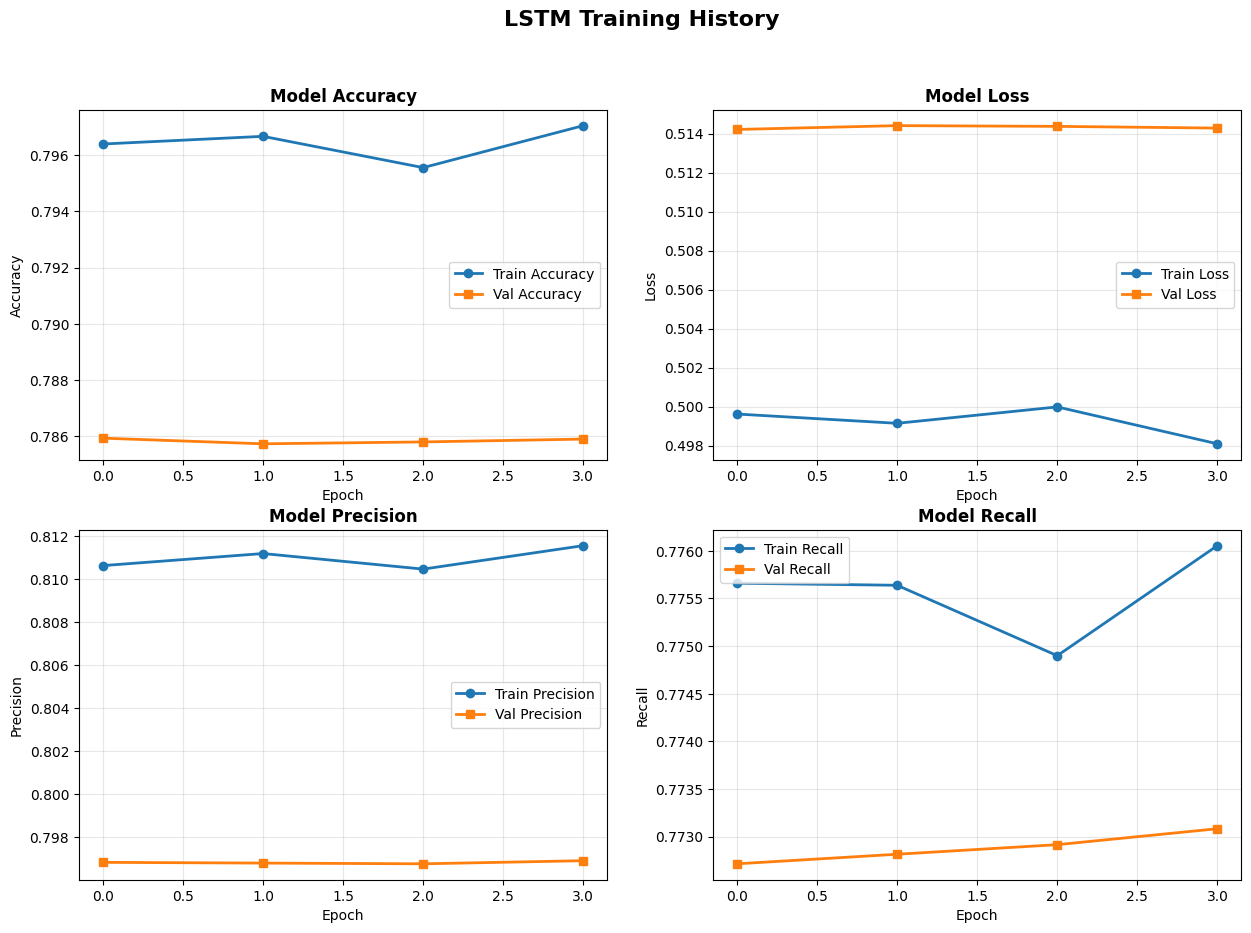

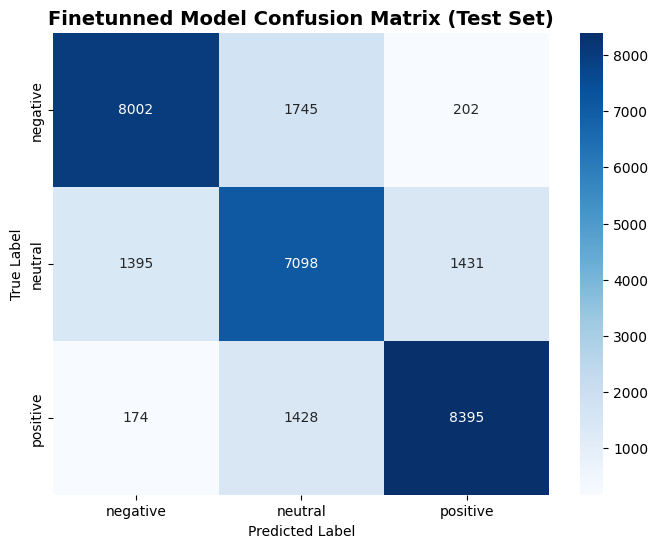

In [22]:
# Results

# Load training history
print("\nLoading training history...")

with open(finetunned_model_training_history_path, 'rb') as f:
    history_dict = pickle.load(f)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LSTM Training History', fontsize=16, fontweight='bold')

# 1. Accuracy
axes[0, 0].plot(history_dict['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0, 0].plot(history_dict['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss
axes[0, 1].plot(history_dict['loss'], label='Train Loss', linewidth=2, marker='o')
axes[0, 1].plot(history_dict['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision
axes[1, 0].plot(history_dict['precision_1'], label='Train Precision', linewidth=2, marker='o')
axes[1, 0].plot(history_dict['val_precision_1'], label='Val Precision', linewidth=2, marker='s')
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Recall
axes[1, 1].plot(history_dict['recall_1'], label='Train Recall', linewidth=2, marker='o')
axes[1, 1].plot(history_dict['val_recall_1'], label='Val Recall', linewidth=2, marker='s')
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Print statistics
print("Training statistics:")

best_epoch = np.argmax(history_dict['val_accuracy']) + 1
best_val_acc = np.max(history_dict['val_accuracy'])
best_val_loss = np.min(history_dict['val_loss'])
final_train_acc = history_dict['accuracy'][-1]
final_val_acc = history_dict['val_accuracy'][-1]

print(f"\nBest epoch: {best_epoch}/{len(history_dict['loss'])}")
print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"\nFinal epoch:")
print(f"    Train accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"    Val accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Check for overfitting
overfit_gap = final_train_acc - final_val_acc
if overfit_gap > 0.1:
    print(f"\nPotential overfitting detected (gap: {overfit_gap:.4f})")
elif overfit_gap > 0.05:
    print(f"\nSlight overfitting (gap: {overfit_gap:.4f})")
else:
    print(f"\nGood generalization (gap: {overfit_gap:.4f})")

# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\nGenerating Confusion Matrix on Test Set...")
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_cat, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Finetunned Model Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()